### 训练集 测试集 验证集
- 在训练集上训练模型，在验证集上评估模型。一旦找到最佳的参数，就在测试数据上最后测试一次
- 使用验证集的原因：开发模型时，总要调节模型配置，比如超参数的设置(层数 隐藏层节点数) 模型参数的设置(网络的权重)，这个
调节过程需要使用模型在验证数据上的性能作为反馈信号。
- 将数据划分为训练集 测试集 验证集的高级方法:
    - 1.简单留出验证
        - 留出一定比例的数据作为测试集，在剩余的数据上训练模型，然后在测试集上评估模型，为了防止信息泄漏，不能基于测试集来调节模型，所以要保留一个验证集。
   如果可用的数据很少，那么可能验证集和测试集包含的样本就太少，从而无法在统计学上代表数据。
这个问题很容易发现：如果在划分数据前进行不同的随机打乱，最终得到的模型性能差别很大，那么就存在这个问题。
    - 2.K折验证
        - K 折验证（ K-fold validation）将数据划分为大小相同的 K 个分区。 对于每个分区 i，在剩余的 K-1 个分区上训练模型，然后在分区 i 上评估模型。最终分数等于 K 个分数的平均值。对
于不同的训练集 - 测试集划分，如果模型性能的变化很大，那么这种方法很有用。与留出验证一样，这种方法也需要独立的验证集进行模型校正。
    - 3. 带有打乱数据的重复 K 折验证
        - 如果可用的数据相对较少，而你又需要尽可能精确地评估模型，那么可以选择带有打乱数据的重复 K 折验证（ iterated K-fold validation with shuffling）。我发现这种方法在 Kaggle 竞赛中特别有用。具体做法是多次使用 K 折验证，在每次将数据划分为 K 个分区之前都先将数据打乱。最终分数是每次 K 折验证分数的平均值。注意，这种方法一共要训练和评估 P× K 个模型（ P是重复次数），计算代价很大。

In [17]:
############ 留出验证法 ######################
data = np.arange(10)
import numpy as np
num_validation_samples = 10000  # 验证集大小
np.random.shuffle(data)  # 随机打乱数据
## 定义验证集 
validation_data = data[:num_validation_samples]
# 定义训练集
training_data = data[:]
# 训练集上训练模型，验证集上评估模型
model = get_model()
model.train(training_data)
validation_score = model.evaluate(validation_data)
'''调整超参数 重新训练再调节 训练 得到最佳参数'''
# 确定超参数后，在原始数据上测试模型
model = get_model()
model.train(np.concatenate([training_data,
validation_data]))
test_score = model.evaluate(test_data)

NameError: name 'get_model' is not defined

In [ ]:
# K折交叉验证
k = 4
num_validation_samples = len(data) // k
np.random.shuffle(data)
validation_scores = []

for i in range(k):
    # 验证集数据分区
    validation_data = data[num_validation_samples * i:num_validation_samples*(i+1)]
    # 剩下数据作为训练集
    training_data = data[:num_validation_samples*i] + data[num_validation_samples*(i+1):]
    
    model = get_model()
    model.train(training_data)
    validation_score = model.evaluate(validation_data)
    validation_scores.append(validation_score)
    
validation_score = np.average(validation_scores)

# 在所有非测试数据上训练最终模型
model = get_model()
model.train(data)
test_score = model.evaluate(test_data)
    

### 数据预处理
- 1.向量化
神经网络的所有输入和目标都必须是浮点数张量（在特定情况下可以是整数张量）。无论处理什么数据（声音、图像还是文本），都必须首先将其转换为张量，这一步叫作数据向量化
- 2.值标准化
    - 输入数据应该具有以下特征：
        - 取值较小：大部分值都应该在 0~1 范围内
        - 同质性（ homogenous）：所有特征的取值都应该在大致相同的范围内
        - 将每个特征分别标准化，使其平均值为 0  将每个特征分别标准化，使其标准差为 1
        - numpy实现
            ```python
            x -= x.mean(axis=0)
            x /= x.std(axis=0)
            ```
- 3.缺失值处理
    - 一般来说，对于神经网络，将缺失值设置为0是安全的，只要0不是一个有意义的值。网络能够从数据中学到0意味着缺失数据，并且会忽略这个值
    - 注意，如果测试数据中可能有缺失值，而网络是在没有缺失值的数据上训练的，那么网络不可能学会忽略缺失值。在这种情况下，你应该人为生成一些有缺失项的训练样本：多次复制一些训练样本，然后删除测试数据中可能缺失的某些特征
           
### 特征工程
- 特征工程（ feature engineering）是指将数据输入模型之前，利用你自己关于数据和机器学习算法（这里指神经网络）的知识对数据进行硬编码的变换（不是模型学到的），以改善模型的效果。多数情况下，一个机器学习模型无法从完全任意的数据中进行学习，呈现给模型的数据应该便于模型进行学习


### 过拟合和欠拟合

In [19]:
from keras.datasets import imdb

Using TensorFlow backend.


In [20]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [21]:
word_index = imdb.get_word_index() 

In [22]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])  # 键值颠倒，将整数索引映射为单词
decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]]) # 将评论解码，将索引减去3,由于0,1,2是填充

In [23]:
import numpy as np

def vectorize_squences(squences, dimension=10000):
    results = np.zeros((len(squences), dimension))
    for i, sequence in enumerate(squences):
        results[i, sequence] = 1.
        return results

In [26]:
# 将训练和测试数据向量化，采用one-hot编码

x_train = vectorize_squences(train_data)
x_test = vectorize_squences(test_data)

In [27]:
# 标签向量化
y_train = np.asarray((train_labels).astype('float32'))
y_test = np.asarray((test_labels).astype('float32'))

In [28]:
from keras import models
from keras import layers

#模型定义

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [29]:
# 编译模型

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [30]:
# 配置优化器

from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
# 留出验证集---------将原始训练数据留出10000个样本作为验证集合

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [32]:
#训练模型

model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(partial_x_train,
partial_y_train,
epochs=20,
batch_size=512,
validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 4s - loss: 0.6931 - acc: 0.5035 - val_loss: 0.6932 - val_acc: 0.4948
Epoch 2/20
15000/15000 [==============================] - 2s - loss: 0.6931 - acc: 0.5035 - val_loss: 0.6932 - val_acc: 0.4948
Epoch 3/20
15000/15000 [==============================] - 2s - loss: 0.6931 - acc: 0.5035 - val_loss: 0.6932 - val_acc: 0.4948
Epoch 4/20
15000/15000 [==============================] - 2s - loss: 0.6931 - acc: 0.5035 - val_loss: 0.6932 - val_acc: 0.4948
Epoch 5/20
15000/15000 [==============================] - 2s - loss: 0.6931 - acc: 0.5035 - val_loss: 0.6932 - val_acc: 0.4948
Epoch 6/20
15000/15000 [==============================] - 2s - loss: 0.6931 - acc: 0.5035 - val_loss: 0.6932 - val_acc: 0.4948
Epoch 7/20
15000/15000 [==============================] - 2s - loss: 0.6931 - acc: 0.5035 - val_loss: 0.6932 - val_acc: 0.4948
Epoch 8/20
15000/15000 [==============================] - 2s 

In [33]:
history_dict = history.history  # model.fit()方法返回一个history对象，调用此对象下的history方法，可以查看训练中的所有数据
history_dict.keys()  # 对应训练和测试中的监控指标

dict_keys(['val_loss', 'acc', 'loss', 'val_acc'])

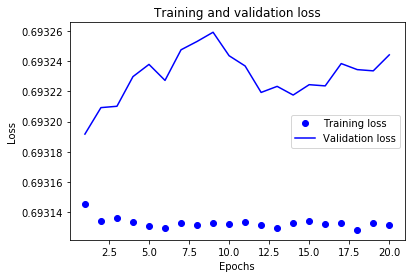

In [34]:
import matplotlib.pyplot as plt

%matplotlib inline

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

### 奥卡姆剃刀（ Occam’s razor）原理：如果一件事情有两种解释，那么最可能正确的解释就是最简单的那个，即假设更少的那个

### 添加正则化
- L1 正则化（ L1 regularization）：添加的成本与权重系数的绝对值［权重的L1范数（ norm）］成正比。
- L2 正则化（ L2 regularization）：添加的成本与权重系数的平方（权重的L2范数）成正比。神经网络的 L2 正则化也叫权重衰减（weight decay）。不要被不同的名称搞混，权重衰减与 L2 正则化在数学上是完全相同的。

In [35]:
# 添加l2正则化
from keras import regularizers
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# l2(0.001)的意思是该层权重矩阵的每个系数都会使网络总损失增加 0.001 * weight_coefficient_value。注意，由于这个惩罚项只在训练时添加

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [36]:
# 添加l1正则化

from keras import regularizers
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.001),activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.001),activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [38]:
# 同时添加l1  l2正则化

from keras import regularizers
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [40]:
# 添加 dropout 正则化
# 在 Keras 中，你可以通过 Dropout 层向网络中引入 dropout， dropout 将被应用于前面一层的输出。
from keras import regularizers
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

### 防止神经网络过拟合的常用方法：
- 获取更多的训练数据
- 减小网络容量
- 添加权重正则化
- 添加 dropout

### 机器学习的通用工作流程：
- 定义问题，收集数据集
- 选择衡量成功的指标
    - 对于平衡分类问题（每个类别的可能性相同），精度和接收者操作特征曲线下面积（ area under the receiver operating characteristic curve， ROC AUC）是常用的指标。
    - 对于类别不平衡的问题，你可以使用准确率和召回率。
    - 对于排序问题或多标签分类，你可以使用平均准确率均值（ mean average precision）。
- 确定评估方法
    - 留出验证集。数据量很大时可以采用这种方法。
    - K 折交叉验证。如果留出验证的样本量太少，无法保证可靠性，那么应该选择这种方法。
    - 重复的 K 折验证。如果可用的数据很少，同时模型评估又需要非常准确，那么应该使用这种方法
- 准备数据
    - 如前所述，应该将数据格式化为张量。
    - 这些张量的取值通常应该缩放为较小的值，比如在 [-1, 1] 区间或 [0, 1] 区间。
    - 如果不同的特征具有不同的取值范围（异质数据），那么应该做数据标准化。
    - 你可能需要做特征工程，尤其是对于小数据问题。
- 开发第一个比基准更好的模型，即一个具有统计功效的模型。
    - 需要选择三个关键参数来构建第一个工作模型
        - 最后一层的激活。它对网络输出进行有效的限制。
        - 损失函数。它应该匹配你要解决的问题的类型
        - 优化配置。你要使用哪种优化器？学习率是多少？大多数情况下，使用rmsprop及其默认的学习率是稳妥的。
        <hr>
        | 问题类型   |    最后一层激活      | 损失函数 |

        | 二分类问题 | sigmoid            | binary_crossentropy |

        | 多分类、单标签问题 | softmax      | categorical_crossentropy |

        | 多分类、多标签问题 | sigmoid      | binary_crossentropy |

        | 回归到任意值      | 无            | mse |

        | 回归到 0~1 范围内的值 | sigmoid   | mse或binary_crossentropy |
- 扩大模型规模：开发过拟合的模型
    - (1) 添加更多的层。
    - (2) 让每一层变得更大。
    - (3) 训练更多的轮次。
    - 要始终监控训练损失和验证损失，以及你所关心的指标的训练值和验证值。如果你发现模型在验证数据上的性能开始下降，那么就出现了过拟合。
- 模型正则化与调节超参数
    - 添加 dropout。
    - 尝试不同的架构：增加或减少层数。
    - 添加 L1 和 / 或 L2 正则化。
    - 尝试不同的超参数（比如每层的单元个数或优化器的学习率），以找到最佳配置。
    - 反复做特征工程：添加新特征或删除没有信息量的特征。
